_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Student name: FILL IN YOUR NAMES HERE

# Coding Lab 3

- __Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `scipy.signal.decimate`.

In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-05-20 22:20:20Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.18.1

sklearn: 1.4.2

scipy     : 1.13.0
seaborn   : 0.13.2
matplotlib: 3.8.4
numpy     : 1.26.4
pandas    : 2.2.2

Watermark: 2.4.3



In [134]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [135]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)

In [136]:
ogb_calcium.shape, ogb_spikes.shape, gcamp_calcium.shape, gcamp_spikes.shape

((71986, 11), (71986, 11), (23973, 37), (23973, 37))

In [137]:
ogb_spikes.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0


## Task 0: Resampling

In [138]:
# set resampling factor 100 /25 = 4
q = 4

print(
    "shapes before resampling:",
    ogb_calcium.shape,
    ogb_spikes.shape,
    gcamp_calcium.shape,
    gcamp_spikes.shape,
)


def resample(x: pd.DataFrame, q: int, use_scipy=True) -> pd.DataFrame:
    """
    Resamples the input DataFrame by using SciPy's decimate function or summing over non-overlapping blocks of rows.

    Parameters:
    - x: pd.DataFrame
        The input DataFrame with spike signals in each column.
    - q: int
        The downsampling factor. The number of rows in the output will be the original number of rows divided by this factor.
    - use_scipy: bool, default=True
        If True, uses SciPy's decimate function to downsample the DataFrame. If False, sums over non-overlapping blocks of size `q`.

    Returns:
    - pd.DataFrame
        The resampled DataFrame.
    """
    if use_scipy:
        return pd.DataFrame(
            signal.decimate(x, q=q, axis=0),
            columns=np.arange(0, x.shape[1]).astype("str"),
        )
    else:
        # trim to a multiple of the factor q
        n = x.shape[0]
        m = n // q
        x.drop(x.tail(n - (m * q)).index, inplace=True)

        # put every entry into non-overlapping bins
        x["bin"] = np.arange(0, m).repeat(q)

        # sum over the bins
        resampled_x = x.groupby(["bin"]).sum()

        return resampled_x


# resample the calcium signal with scipy.signal.decimate
ogb_calcium_25 = resample(ogb_calcium, q=q)
gcamp_calcium_25 = resample(gcamp_calcium, q=q)

# resample the spike signal, that does not work with the scipy function, because it is a int signal
ogb_spikes_25 = resample(ogb_spikes, q=q, use_scipy=False)
gcamp_spikes_25 = resample(gcamp_spikes, q=q, use_scipy=False)

print(
    "shapes after resampling:",
    ogb_calcium_25.shape,
    ogb_spikes_25.shape,
    gcamp_calcium_25.shape,
    gcamp_spikes_25.shape,
)

shapes before resampling: (71986, 11) (71986, 11) (23973, 37) (23973, 37)
shapes after resampling: (17997, 11) (17996, 11) (5994, 37) (5993, 37)


In [139]:
ogb_calcium[ogb_calcium["2"].isnull()]

,0,1,2,3,4,5,6,7,8,9,10
35993,1.113345,0.948796,NaN,0.410645,0.778496,0.640562,1.084575,-0.024480,-0.091477,0.999115,1.534562
35994,1.205990,0.597999,NaN,0.332083,0.764253,0.491584,1.204120,-0.054393,0.063616,0.813817,1.420545
35995,1.313253,0.192244,NaN,0.258020,0.693189,0.519668,1.351348,-0.102754,0.269145,0.630903,1.333991
35996,1.380866,-0.022966,NaN,0.173295,0.571627,0.619091,1.401515,-0.137990,0.315778,0.595053,1.382474
35997,1.359710,-0.007784,NaN,0.096590,0.446460,0.624469,1.339037,-0.138702,0.196466,0.701137,1.555381
...,...,...,...,...,...,...,...,...,...,...,...
71981,0.538533,0.399124,NaN,0.821013,-0.170785,1.158751,0.682918,0.148761,0.652645,NaN,0.783607
71982,0.712870,0.418369,NaN,0.838734,-0.260950,1.180239,0.313320,0.151934,0.660206,NaN,0.786171
71983,0.670323,0.356299,NaN,0.842801,-0.264011,1.228860,0.215326,0.221346,0.631483,NaN,0.687742
71984,0.355962,0.335461,NaN,0.759840,-0.186234,1.177698,0.688985,0.307233,0.545631,NaN,0.590033


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

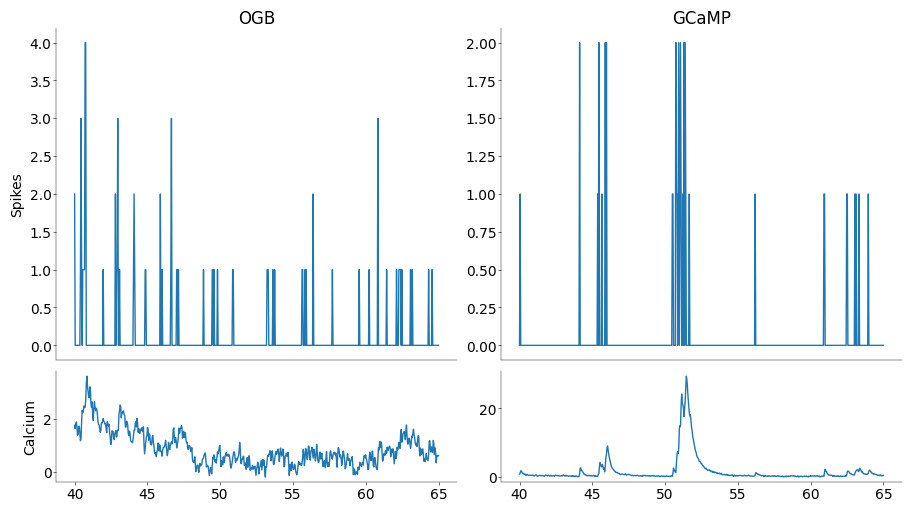

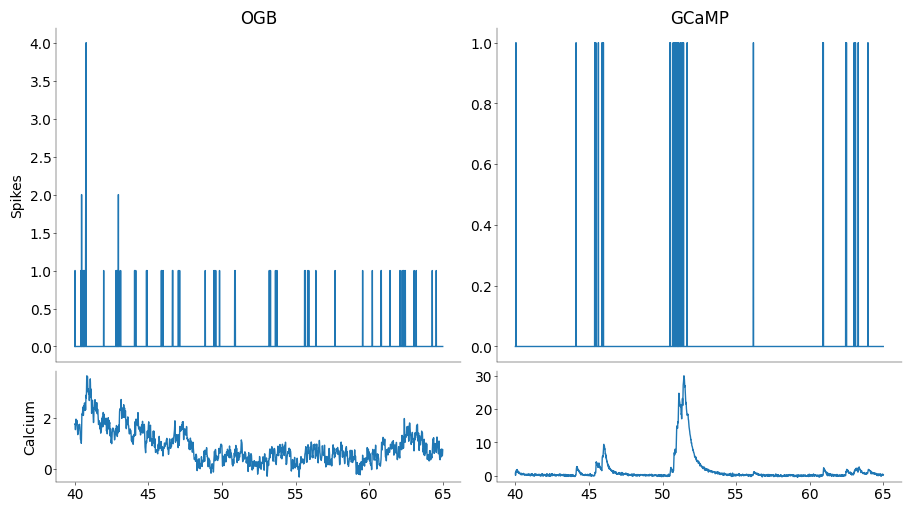

In [146]:
# ----------------------------
# Plot raw calcium data (1 pt)
# ----------------------------

# --------------------------
# Plot raw spike data (1 pt)
# --------------------------
SHOWPRERESAMPLED = True

fig, axs = plt.subplots(
    2, 2, figsize=(9, 5), height_ratios=[3, 1], layout="constrained"
)

# set sampling rate in Hz
fs = 25

# set time-window in s
start = 40
duration = 25
end = start + duration

# convert timewindow to samples
start_s = start * fs
duration_s = duration * fs
end_s = end * fs

# create time linspace
time = np.linspace(start, end, duration_s)

# plot raw ogb data of Cell 5
axs[0, 0].plot(time, ogb_spikes_25["5"][start_s:end_s])
axs[1, 0].plot(time, ogb_calcium_25["5"][start_s:end_s])

# plot raw gcamp data of cell 6
axs[0, 1].plot(time, gcamp_spikes_25["6"][start_s:end_s])
axs[1, 1].plot(time, gcamp_calcium_25["6"][start_s:end_s])

# first row does not need x-axis
axs[0, 0].set_xticks([])
axs[0, 1].set_xticks([])

# set the column names for the subplots
axs[0, 0].set_title("OGB")
axs[0, 1].set_title("GCaMP")

# set the row names for the subplots
axs[0, 0].set_ylabel("Spikes")
axs[1, 0].set_ylabel("Calcium")

plt.show()

if SHOWPRERESAMPLED:
    fig, axs = plt.subplots(
        2, 2, figsize=(9, 5), height_ratios=[3, 1], layout="constrained"
    )

    # set sampling rate in Hz
    fs = 100

    # set time-window in s
    start = 40
    duration = 25
    end = start + duration

    # convert timewindow to samples
    start_s = start * fs
    duration_s = duration * fs
    end_s = end * fs

    # create time linspace
    time = np.linspace(start, end, duration_s)

    # plot raw ogb data of Cell 5
    axs[0, 0].plot(time, ogb_spikes["5"][start_s:end_s])
    axs[1, 0].plot(time, ogb_calcium["5"][start_s:end_s])

    # plot raw gcamp data of cell 6
    axs[0, 1].plot(time, gcamp_spikes["6"][start_s:end_s])
    axs[1, 1].plot(time, gcamp_calcium["6"][start_s:end_s])

    # first row does not need x-axis
    axs[0, 0].set_xticks([])
    axs[0, 1].set_xticks([])

    # set the column names for the subplots
    axs[0, 0].set_title("OGB")
    axs[0, 1].set_title("GCaMP")

    # set the row names for the subplots
    axs[0, 0].set_ylabel("Spikes")
    axs[1, 0].set_ylabel("Calcium")

    plt.show()

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this.

*Grading: 3 pts*


In [141]:
def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """

    # insert your code here

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------

    # low pass filter

    #

    return sp_hat

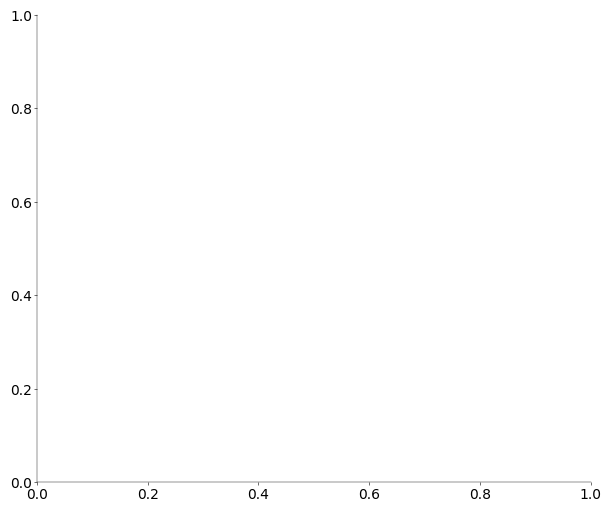

In [142]:
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")

# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------

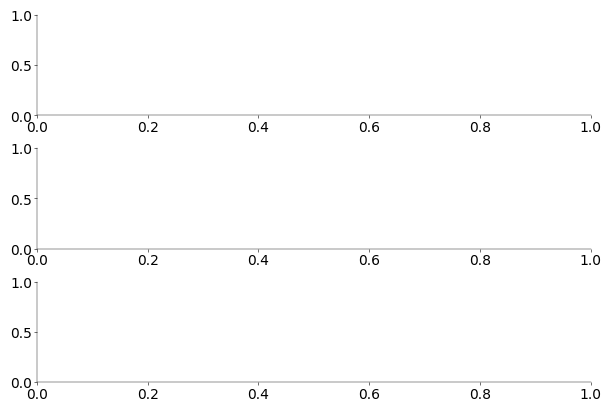

In [143]:
# --------------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB or GCamP Cell (1 pt)
# --------------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 2 pts*



In [144]:
# run this cell to download the oopsi.py file if you haven't already mannually downloaded it
# and put it in the same folder as this notebook
!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [145]:
import oopsi

ModuleNotFoundError: No module named 'oopsi'

In [ ]:
# --------------------------------------------------------------
# Apply one of the advanced algorithms on the OGB Cell (0.5 pts)
# --------------------------------------------------------------

In [ ]:
# -------------------------------------------
# Plot the results for the OGB Cell (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

In [ ]:
# ----------------------------------------------------------------
# Apply one of the advanced algorithms on the GCamP Cell (0.5 pts)
# ----------------------------------------------------------------

In [ ]:
# ---------------------------------------------
# Plot the results for the GCamp Cell (0.5 pts)
# ---------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)


# GCamP Cell

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [ ]:
# -------------------------------------------------
# Create dataframe for OGB Cell as described (1 pt)
# -------------------------------------------------

Create OGB dataframe

In [ ]:
df_ogb = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
df_ogb.head()

Evaluate on GCamp data

In [ ]:
# ---------------------------------------------------
# Create dataframe for GCamP Cell as described (1 pt)
# ---------------------------------------------------

Create GCamp dataframe

In [ ]:
df_gcamp = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
df_gcamp.head()

Combine both dataframes and plot

In [ ]:
# ---------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described (1 pt)
# hint: you can seperate the algorithms by color
# ---------------------------------------------------------------------------